# Hi

In [1]:

import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg as sla


In [2]:
%matplotlib notebook
plt.style.use('ggplot')

## Create dataset 

Moving wave signal in 1-D with some random noise thrown in.

* Variables are the different x positions, specifically the value of the amplitude at that x position
* Samples are different time steps

Thus, our data matrix is $N$ samples by $M$ variables, where $N$ is the number of timesteps and $M$ the number of different x positions. 

<IPython.core.display.Javascript object>


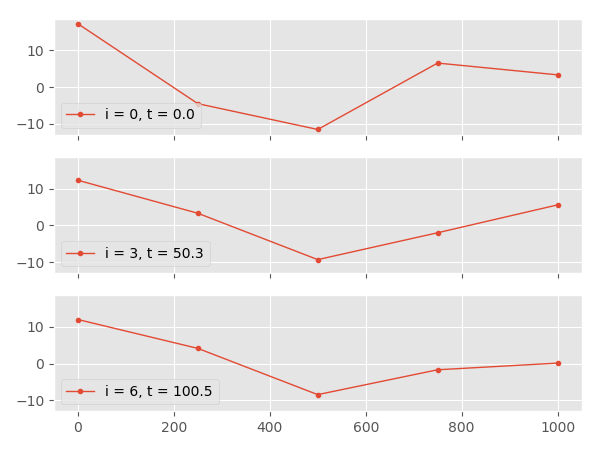

In [3]:
#> signal will be a sum of 3 waves
wls = np.array([1000, 700, 400])  # wavelength (in x direction)
ks = 2*np.pi/wls  # wavenumber in x direction
C = 10  # speed of mean wind advecting the waves
cs = np.array([10, 50, 100])  # wave speed
ws = 2*np.pi/cs  # wave angular frequency omega
As = np.array([10, 5, 2])  # amplitudes
A_noise = 0.5

def clean_sig(t, x):
    """Compute sum of the wave signals with their properties listed above
    only properly broadcasts for float x"""
    return ( As*np.cos(ks*x - ws*t) ).sum()
clean_sig = np.vectorize(clean_sig)

N = 200
M = 5
x = np.linspace(0, 1000, M)
t = np.linspace(0, 10000, N)

X = np.zeros((N, M))  # pre-allocate data matrix
for i, t_i in enumerate(t):
    X[i,:] = clean_sig(t_i, x) + np.random.normal(loc=0, scale=A_noise, size=x.size)

    
i_plots = [0, 3, 6]
f1, aa = plt.subplots(len(i_plots), 1, num='time series',
                      figsize=(6, 4.5), sharex=True, sharey=True)
for i, i_plot in enumerate(i_plots):
    ax = aa[i]
    l = 'i = {i:d}, t = {t:.1f}'.format(i=i_plot, t=t[i])
    ax.plot(x, X[i_plot,:], '.-', lw=1, label=l)
    ax.legend(loc='lower left')

#ax.set_xlabel('x')
#ax.set_ylabel('t')
f1.tight_layout();

## Implement PCA

<IPython.core.display.Javascript object>


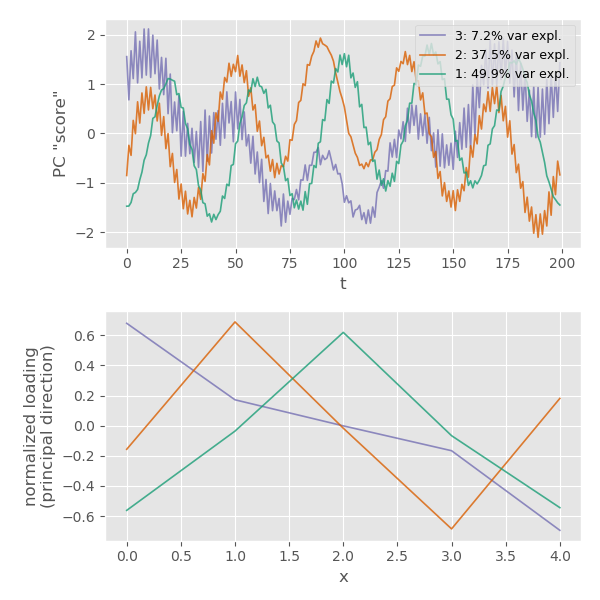

In [4]:
Xp = X - X.mean(axis=0)

#> SVD
U, s, V_T = sla.svd(Xp, full_matrices=False)
S = sla.diagsvd(s, *X.shape)
V = V_T.T

#> calculate PCA stuff from the SVD results
PCs = X @ V  # principal components (columns)
normalized_PCs1 = np.sqrt(N-1) * U
PDs = V      # principal directions (cols)
eigvals = s**2/(N-1)
eigvals0 = eigvals.copy()
normalized_PCs2 = (PCs - PCs.mean(axis=0))/np.sqrt(eigvals)

#loadings = np.sqrt(eigs) * PDs  # loadings (cols)
#loadings = np.sqrt(eigs)[np.newaxis,:] * PDs
#loadings = np.diag(np.sqrt(eigs)) @ PDs  # incorrect!
loadings = PDs @ np.diag(np.sqrt(eigvals))

var_expl = eigvals/eigvals.sum()

#> some checks
#assert(np.allclose(PCs.T @ PCs, np.eye(N)))
assert(np.allclose(PDs.T @ PDs, np.eye(M)))  # principal directions are orthog
assert(np.allclose(loadings.T @ loadings, np.eye(M)*eigvals))  # loadings too, though the matrix is not !
assert(np.allclose(sla.norm(loadings, axis=0), np.sqrt(eigvals)))  # check loading vectors are scaled correctly
assert(np.isclose(np.trace(loadings.T @ loadings), eigvals.sum()))
assert(np.allclose(np.corrcoef(PCs.T), np.eye(M)))  # PCs are uncorrelated
#assert(np.isclose(np.trace(normalized_PCs2.T @ normalized_PCs2), np))
assert(np.allclose(normalized_PCs1, normalized_PCs2))

#> plot
n_retain = 3

colors = plt.cm.Dark2(np.linspace(0, 1, 8))[:8]
leg_fs = 9

f2, [a1, a2] = plt.subplots(2, 1, figsize=(6, 6), num='PCs')

for j in range(n_retain-1, 0-1, -1):  # plot PCs in reverse order
    s = '{:d}: {:.1f}% var expl.'.format(j+1, var_expl[j]*100)
    pc_j = PCs[:,j]
    alpha = 0.2 + 0.6*(n_retain-1-j)/(n_retain-1) if n_retain>4 else 0.8
    #print(pc_j.mean())
    a1.plot((pc_j - pc_j.mean())/np.sqrt(eigvals[j]), 
           c=colors[j], lw=1.2, alpha=alpha, label=s)

    a2.plot(PDs[:,j], c=colors[j], lw=1.2, alpha=alpha)
    

a1.set_xlabel('t')
a1.set_ylabel('PC "score"')
a2.set_xlabel('x')
a2.set_ylabel('normalized loading\n(principal direction)')
    
ncol = 1 if n_retain <= 4 else 2
a1.legend(loc='upper right', ncol=ncol, fontsize=leg_fs, frameon=True)

f2.tight_layout();

## Apply varimax rotation

Adapted from https://github.com/EducationalTestingService/factor_analyzer/blob/master/factor_analyzer/rotator.py

sum PDs_rot . PDs_rot = 3.0


<IPython.core.display.Javascript object>


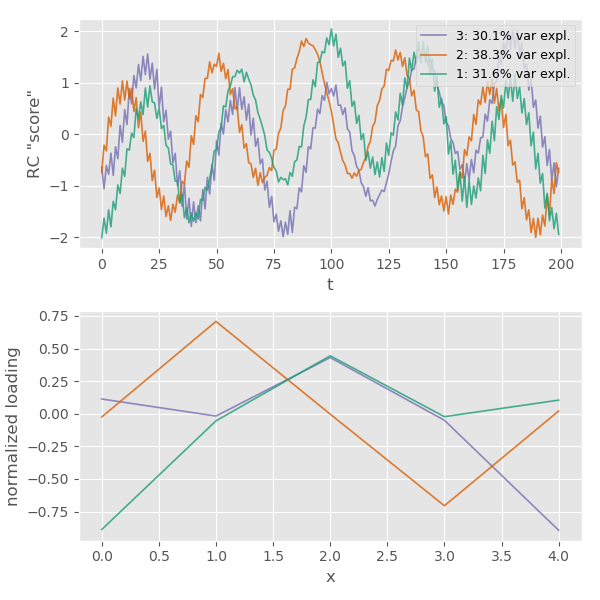

In [5]:

normalize = True
max_iter = 500
tolerance = 1e-8

L = loadings[:,:n_retain].copy()  # or can use the PDs??

n_rows, n_cols = L.shape

# optional Kaiser normalization
if normalize:
    norms = sla.norm(L, axis=1)[:,np.newaxis] # ??
    L = 1/norms * L

# initialize the rotation matrix
# to N x N identity matrix
T = np.eye(n_cols)

d = 0
for i in range(max_iter):

    old_d = d

    # take inner product of loading matrix
    # and rotation matrix
    basis = L @ T

    # transform data for singular value decomposition
    transformed = L.T @ (basis**3 - (1.0/n_rows) *
                  (basis @ np.diag(np.diag(basis.T @ basis))) )

    # perform SVD on
    # the transformed matrix
    U, s, V_T = sla.svd(transformed)

    # take inner product of U and V, and sum of S
    T = U @ V_T  # rotation matrix
    d = s.sum()

    # check convergence
    if old_d != 0 and d/old_d < 1 + tolerance:
        break

# take inner product of loading matrix
# and rotation matrix
Lp = L @ T

# de-normalize the data
if normalize:
    Lp = norms * Lp
#else:
#    Lp = Lp.T


norms = sla.norm(Lp, axis=0)
eigvals = norms**2
var_expl = eigvals/eigvals.sum()

#PDs_rot = 1/norms * Lp
PDs_rot = PDs[:,:n_retain] @ T
#assert(np.allclose(PDs_rot, V.T[:,:n_retain]))

#> new PCs (no longer principal. maybe should be called rotated components (RCs) or rotated factors)
#  these three methods should give the same thing
#RCs = X @ sla.pinv(Lp).T
#RCs = X @ PDs_rot
RCs = PCs[:,:n_retain] @ T 
#RCs = X @ Lp  # this one is technically incorrect though, although the standardized RCs will be the same...

#> some checks
assert(np.allclose(T.T @ T, np.eye(n_retain)))  # orthogonal rotation means the transformation matrix is orthog
assert(np.isclose(np.trace(np.corrcoef(RCs.T)), n_retain))  # RCs should be still uncorrelated
assert(np.allclose(PDs_rot.T @ PDs_rot, np.eye(n_retain)))  # axes still orthog (this is an orthogonal rotation!)
assert(not np.allclose(Lp.T @ Lp, np.eye(n_retain)*eigvals))  # loading vectors no longer orthog!
print('sum PDs_rot . PDs_rot = {:.3}'.format((PDs_rot.T @ PDs_rot).sum()))
assert(np.isclose(eigvals0[:n_retain].sum(), eigvals.sum()))  # same total amount of variance in data explained!


f3, [a1, a2] = plt.subplots(2, 1, figsize=(6, 6), num='rotated components')

for j in range(n_retain-1, 0-1, -1):  # plot PCs in reverse order
    s = '{:d}: {:.1f}% var expl.'.format(j+1, var_expl[j]*100)
    pc_j = RCs[:,j]
    alpha = 0.2 + 0.6*(n_retain-1-j)/(n_retain-1) if n_retain>4 else 0.8
    a1.plot((pc_j - pc_j.mean())/np.sqrt(eigvals[j]),
           c=colors[j], lw=1.2, alpha=alpha, label=s)

    a2.plot(PDs_rot[:,j], c=colors[j], lw=1.2, alpha=alpha)
    

a1.set_xlabel('t')
a1.set_ylabel('RC "score"')
a2.set_xlabel('x')
a2.set_ylabel('normalized loading')
    
ncol = 1 if n_retain <= 4 else 2
a1.legend(loc='upper right', ncol=ncol, fontsize=leg_fs, frameon=True)

f3.tight_layout();

Note that
```python
np.array([1, 2, 3])[:,np.newaxis] * np.ones((3, 3))
== array([[1., 2., 3.],
          [1., 2., 3.],
          [1., 2., 3.]])
```
To broadcast along cols instead we do
```python
np.array([1, 2, 3])[:,np.newaxis] * np.ones((3, 3))
== array([[1., 1., 1.],
          [2., 2., 2.],
          [3., 3., 3.]])
```